-------------------------
The Data have:
	772 rows
	46 columns

-------------------------
Columns types distribution:

object     35
float64     8
int64       3
dtype: int64
-------------------------
Now There is no NaN value in our Data
-------------------------
Added 3 String Features (Extracted from numerical variables)

-------------------------
<Rare case> catagory count:
PRE_REGISTRATION_NUMBER_first_portion       8.0
SEPARATED_REFERENCE_str                    12.0
AREA_NAME_EN                               13.0
MUNC_ZIP_CODE_str                          13.0
CURRENT_STATUS_month_name                  15.0
SEPARATED_FROM_str                         15.0
CURRENT_STATUS_week_category               16.0
CURRENT_STATUS_day_name                    16.0
CREATION_week_category                     17.0
CURRENT_STATUS_year_category               17.0
CURRENT_STATUS_after_min_date              18.0
CURRENT_STATUS_year_after_min_year_str     27.0
CREATION_after_min_date                    7

/home/amir/.local/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


-------------------------

NOTE: This summary saved as <summary_OLS_1.csv>


-------------------------
 --- Model statistic --- 

R-squared         : 0.981
Adj. R-squared    : 0.973
F-statistic       : 126)
Prob (F-statistic): 6.77680755819959e-281
No. Observations  : 579
AIC               : 18058
Df Residuals      : 411
BIC               : 18791
RMSE (test)       : 18498353


-------------------------
Maximum correlation between Reseduals and any data columns is 3.082238630574499e-14, with columns <tree_3>
Mean of train reseduals: 3.503317042335945e-08
-------------------------
RF model peramters:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,


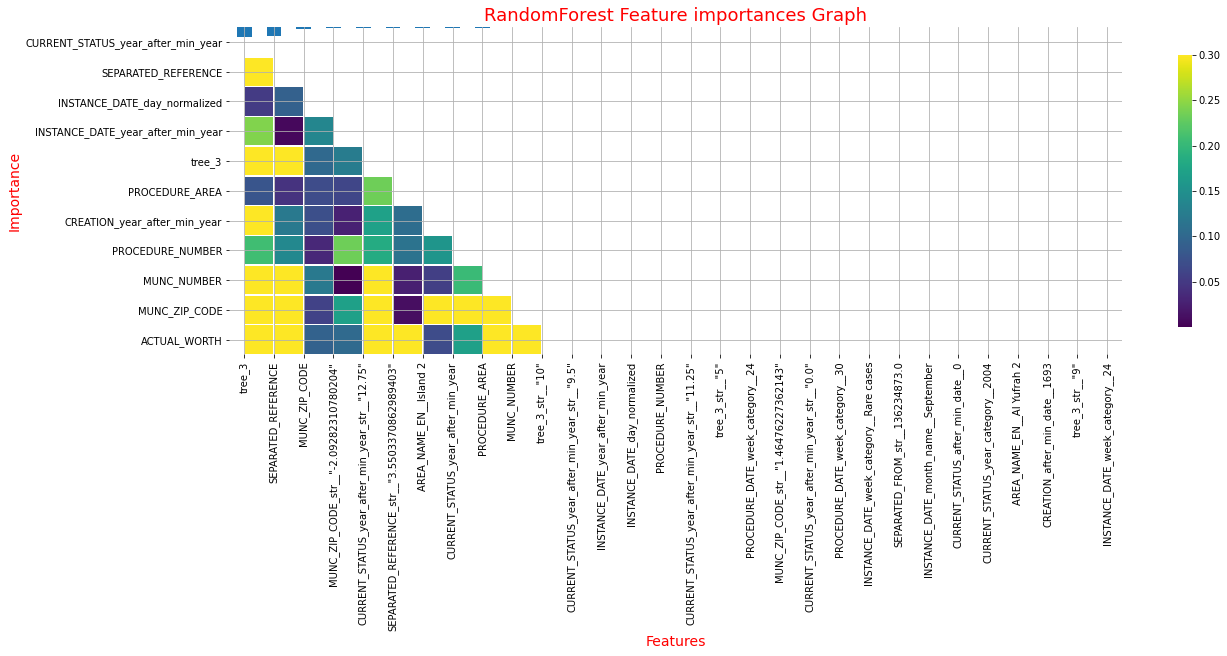

-------------------------
R^2 (test) : 0.5371736562140328
R^2 (train): 0.9826473692594582
RMSE (test): 8645902
oob score  : 0.8685097092657614
-------------------------
Maximum correlation between Reseduals and any data columns is 0.5537081692886814, with columns <PROCEDURE_AREA>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def new_line():
    print("-------------------------")

def RMSE(predictions):
    return round(np.sqrt(((test_y - predictions)**2).mean()))

def plot_numerical_columns(col_name):
    return None
    df[col_name].plot(figsize=(13,8));
    plt.title(col_name, size=18);
    plt.axhline(y=df[col_name].mean(), color='red');
    plt.axhline(y=df[col_name].median(), color='green');
    plt.legend(['Actual', 'Mean', 'Median']);
    plt.show()

    df[col_name].sort_values().reset_index(drop=True).plot(figsize=(13,8));
    plt.title(col_name+" (SORTED)", size=18);
    plt.axhline(y=df[col_name].mean(), color='red');
    plt.axhline(y=df[col_name].median(), color='green');
    plt.legend(['Actual', 'Mean', 'Median']);
    plt.show()

    df[col_name].plot(kind="box", figsize=(13,8))
    plt.title(col_name, size=18);
    plt.xlabel("");
    plt.show()

def plot_date_columns(col_name):
    return None
    df[col_name].plot(figsize=(15,7), grid=True);
    plt.xlabel("Index", size=14);
    plt.ylabel("Date", size=14);
    plt.title(col_name + " Graph", size=18);
    plt.show();

    df[col_name].sort_values().reset_index(drop=True).plot(figsize=(15,7), grid=True);
    plt.xlabel("Index (sorted)", size=14);
    plt.ylabel("Year", size=14);
    plt.title(col_name + " Graph", size=18);
    plt.show();

    (df[col_name].dt.year.value_counts(sort=False).sort_index() / len(df) * 100).plot(kind="bar", figsize=(15,7), grid=True);
    plt.xlabel("Year", size=14);
    plt.ylabel("Ratio (1-100)", size=14);
    plt.title(col_name + " year Frequency Graph", size=18);
    plt.show();

    (df[col_name].dt.month.value_counts().sort_index()/len(df) * 100).plot(kind="bar", figsize=(15,7), grid=True);
    plt.xlabel("Month", size=14);
    plt.ylabel("Ratio (1-100)", size=14);
    plt.title(col_name + " month Frequency Graph", size=18);
    plt.show();

    (df[col_name].dt.day.value_counts().sort_index()/len(df) * 100).plot(kind="bar", figsize=(15,7), grid=True);
    plt.xlabel("Day", size=14);
    plt.ylabel("Ratio (1-100)", size=14);
    plt.title(col_name + " Day Frequency Graph", size=18);
    plt.show();

def plot_catagorical_columns(cat_variable):
    return None
    (df[cat_variable].value_counts() / len(df) * 100).plot.bar(figsize=(15,6), grid=True);
    plt.title(cat_variable, size=18, color='r');
    plt.xlabel("Catagory", size=14, color='r');
    plt.ylabel("Ratio (1-100)", size=14, color='r');
    plt.show()

def data_shape():
    return f"The Data have:\n\t{df.shape[0]} rows\n\t{df.shape[1]} columns\n"
#===
# df = pd.read_csv("data.csv", date_parser=True)

df = pd.read_csv("df_only_selected_columns_using_PCA.csv", date_parser=True)
target_variable = "ACTUAL_WORTH"

# df = pd.read_csv("cleaned_data.csv", date_parser=True)
# target_variable = "SalePrice"
#===
f = df[target_variable].isna().sum()
if f:
    new_line()
    print(f"There are {f} NAs in target values, we droped those rows")
    df = df[df[target_variable].notna()]
del f
#---------------------------------------------------
# df.select_dtypes("O").columns[:5]
# D = df.select_dtypes(exclude="O")
# D2 = df.select_dtypes("O").iloc[:,:5]
# df = pd.concat([D, D2], 1)

# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
# profile.to_file("your_report.html")
#---------------------------------------------------
new_line()
print(data_shape())
#===
new_line()
print(f"Columns types distribution:\n\n{df.dtypes.value_counts()}")
#---------------------------------------- NA
a = df.isna().sum().where(lambda x:x>0).dropna()
if a.size:
    new_line()
    print(f"There are {len(a)} (out of {df.shape[1]}, [{round(len(a)/df.shape[1]*100)}%]) columns that contains 1 or more NA")
#===
a = a.sort_values()/len(df)*100
if (a == 100).sum():
    new_line()
    df.drop(columns=a[a==100].index, inplace=True)
    print(f"There are {(a == 100).sum()} columns that are all Missing values, so we droped those.\nNow {data_shape()}\n\nDropped columns names:")
    for i in a[a==100].index:
        print("\t",i)
    a = a[a != 100]
#===
x = df[a.index].dtypes.value_counts()
if x.size:
    new_line()
    print(f"NA columns data type Distribution:\n\n{x}")
del x
#===
new_line()
if a.size:
    print(f"NaN Ratio (0-100)\n\n{a}")
else:
    print("Now There is no NaN value in our Data")
#===
# IMPUTING missing values??????????????
#===
# --------------------------------------------------------- Unique values
only_one_unique_value = df.nunique().where(lambda x:x == 1).dropna()
if only_one_unique_value.size:
    new_line()
    df.drop(columns=only_one_unique_value.index, inplace=True)
    print(f"There are {only_one_unique_value.size} variables That have only one unique value, so we drop those.\n\nNow {data_shape()}\n\nThose columns names in order:\n")
    for i in only_one_unique_value.index.sort_values():
        print(i)
del only_one_unique_value
# #===
all_values_are_unique = df.apply(lambda x:x.is_unique).where(lambda x:x==True).dropna()
if all_values_are_unique.size:
    new_line()
    df.drop(columns=all_values_are_unique.index, inplace=True)
    print(f"There are {all_values_are_unique.size} column/s that have all unique values, so no value repeatation, we droped those columns.\n\nNow {data_shape()}\nThose column/s name/s are:\n")
    for i in all_values_are_unique.index:
        print("\t", i)
del all_values_are_unique
#===
date_columns = []
def DTYPES():
    global date_columns
    catagorical_columns = df.head().select_dtypes("O").columns
    numerical_columns   = df.head().select_dtypes("number").columns
    date_columns        = []

    for i in catagorical_columns:
        try:
            df[i] = pd.to_datetime(df[i])
            date_columns.append(i)
        except:
            pass

    catagorical_columns = catagorical_columns.drop(date_columns)
    if date_columns:
        date_columns = pd.Index(date_columns)
    #===
    if not catagorical_columns.append(numerical_columns).append(date_columns).is_unique:
        new_line()
        print("\nSome column/s repated in > 1 dtypes\n")
        dtypes = pd.DataFrame({"Column" : catagorical_columns.append(numerical_columns).append(date_columns),
                    "dtype" : ['O']*len(catagorical_columns) + ['Number']*len(numerical_columns) + ['Date']*len(date_columns)})
        print(dtypes[dtypes.Column.isin(list(dtypes[dtypes.Column.duplicated()].Column.values))].to_string())
    #===
    x = df.columns.difference(
        catagorical_columns.append(numerical_columns).append(date_columns)
        )
    if x.size:
        new_line()
        print("Some columns not included in any existing catagory, those:\n")
        for i in x:
            print(f"\t<{i}, with dtype of <{df[i].dtype}>")
    #===
    dtypes = pd.DataFrame({"Column" : catagorical_columns.append(numerical_columns).append(date_columns),
                "dtype" : ['Object']*len(catagorical_columns) + ['Number']*len(numerical_columns) + ['Date']*len(date_columns)})
    return dtypes
#===
dtypes = DTYPES()
# ----------------------------------------------------------------------- Feature enginearing
# ======= Adding date columns
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> add polynomial, sqrt, tree, log features
def add_new_date_cols(x, suffix):
    d = {}
    d[suffix + '_week_normalized'] = x.dt.week / 52
    d[suffix + '_week_str'] = '"' + x.dt.week.apply(lambda x:np.nan if np.isnan(x) else str(x).replace(".0", "")) + '"'

    d[suffix + '_year_after_min_year'] = x.dt.year - x.dt.year.min()
    d[suffix + '_year_str'] = '"' + x.dt.year.apply(lambda x:np.nan if np.isnan(x) else str(x).replace(".0", "")) + '"'

    d[suffix + '_day_name']  = x.dt.day_name()

    d[suffix + '_day_after_min_date_str']  = '"' + (x - x.min()).apply(lambda x: str(x).split()[0]) + '"'

    d[suffix + '_day_normalized'] = x.dt.day / 31

    d[suffix + '_hour_normalized'] = x.dt.hour / 24
    d[suffix + '_hour_str'] = '"' + x.dt.hour.apply(lambda x:np.nan if np.isnan(x) else str(x).replace(".0", "")) + '"'

    d[suffix + '_month_name'] = x.dt.month_name()
    d[suffix + '_month_normalized'] = x.dt.month/12
    for k,v in d.items():
        if v.nunique() > 1:
            df[k] = v
    return df.drop(columns=x.name)
    # return df

len_df_before_adding_date_vars = df.shape[1]
for date_col in date_columns:
    df = add_new_date_cols(df[date_col], date_col)
len_df_after_adding_date_vars  = df.shape[1]
if len_df_after_adding_date_vars > len_df_before_adding_date_vars:
    new_line()
    print(f"Added {len_df_after_adding_date_vars - len_df_before_adding_date_vars} date Features\n")
# ======= type casting of numerical variable (those who have < 4% unique values) to catagorical variables
f = (df.select_dtypes("number").nunique() / len(df) * 100).where(lambda x:x<4).dropna().index
if f.size:
    len_df_before_adding_date_vars = df.shape[1]
    for col_num_to_str in f:
        df[col_num_to_str+"_str"] = '"' + df[col_num_to_str].astype(str) + '"'
    len_df_after_adding_date_vars  = df.shape[1]
    new_line()
    print(f"Added {len_df_after_adding_date_vars - len_df_before_adding_date_vars} String Features (Extracted from numerical variables)\n")
# =======
def cluping_rare_cases_in_one_catagory(x):
    global df
    x = df[x]
    orignal  = x.copy("deep")
    xx = x.value_counts()
    xx = xx[xx< 10].index.to_list()
    x =  x.replace(xx , "Rare cases")
    if x.value_counts()[-1] < 8:
        x[x == "Rare cases"] = x.mode()[0] # agar "Rare cases" vali catogery me 8 sy bhi kam values hon to un ko most common value sy replace kar do
    if x.nunique() == 1:
        new_line()
        print(f"The column <{x.name}> have only one unique value, We droped it from the data.")
        # return orignal
        df.drop(columns=x.name, inplace=True)
        return None
    return x

for var in df.select_dtypes("O").columns:
    m = cluping_rare_cases_in_one_catagory(var)
    if isinstance(m, pd.core.series.Series):
        df[var] = m
new_line()
print(f"<Rare case> catagory count:\n{(df == 'Rare cases').sum().sort_values().where(lambda x:x>0).dropna().to_string()}")
# ----------------------------------------------------------------------- END (Feature enginearing)
dtypes = DTYPES()
# ---------------------------------------------------- Correlation plot
cor_df = df.select_dtypes('number').corr().abs()
mask = np.triu(np.ones_like(cor_df, dtype=bool));
f, ax = plt.subplots(figsize=(17, 10));
cmap = sns.color_palette("viridis", as_cmap=True);
plot_ = sns.heatmap(cor_df, mask=mask, cmap=cmap, vmax=.3, square=True, linewidths=.5, cbar_kws={"shrink": .5});
plot_.axes.set_title("abs (Correlation) plot",fontsize=25)
# ---------------------------------------------------------------------
#===
# m = 0
for row in dtypes.iterrows():
    # m += 1
    # if m == 3:
        # break
    column_name, type_ = row[1]
    x = df[column_name]
    print(f"\n\n\n=============================== {column_name} ===============================\n\n")

    for col_ in df.columns:
        if col_ == column_name:
            continue
        if df[col_].nunique() == df[column_name].nunique():
            unique_combination = df[[col_, column_name]].drop_duplicates()
            if unique_combination.apply(lambda x:x.is_unique).sum() == 2:
                new_line()
                print(f"This Columns is duplicate of <{col_}> column")

    print(f"Column Type     : {type_}")
    if x.isna().all():
        new_line()
        df.drop(columns=column_name, inplace=True)
        print("We dropped This column, because it is all Empty")
        continue
    if type_ in ["O", "Date"]:
        if x.is_unique:
            new_line()
            df.drop(columns=column_name, inplace=True)
            print(f"We dropped This column, because it's a {type_} columns, and it's all values are unique")
            continue
    if x.nunique() == 1:
        new_line()
        df.drop(columns=column_name, inplace=True)
        print(f"We dropped This column, because There is only one unique value")
        continue

    if type_ == "Number":
        local_cor = cor_df[column_name].drop(column_name).reset_index()
        local_cor = local_cor.reindex(local_cor[column_name].abs().sort_values().index)
        if local_cor[column_name].max() == 1:
            new_line()
            print(f"This column is perfactly correlated with column <{local_cor[local_cor[column_name] == m]['index'].values[0]}, so remove one of them")
        new_line()
        print(f"Most 3 correlated features with this columns:\n{local_cor[-3:].rename(columns={'index' : 'Column name', column_name : 'Correlation'}).reset_index(drop=True)}\n")

        new_line()
        skewness = x.skew(skipna = True)
        if abs(skewness) < 0.5:
            print(f"The data is fairly symmetrical {skewness}")
        elif abs(skewness) < 1:
            print(f"The data are moderately skewed {skewness}")
        else:
            print(f"The data are highly skewed {skewness}\nNote: When skewness exceed |1| we called it highly skewed")

        # f = x.describe()
        # f['Nunique'] = x.nunique()
        # f['Nunique ratio'] = f.loc["Nunique"] / f.loc["count"] * 100
        # f['Outlies count'] = (((x - x.mean())/x.std()).abs() > 3).sum()
        # f['Outlies ratio'] = f.loc["Outlies count"] / f.loc["count"] * 100
        # f['Nagative values count'] = (x < 0).sum()
        # f['Nagative values ratio'] = f['Nagative values count'] / f['count'] * 100

        ff = [x.count(), x.isna().sum(), x.mean(), x.std(), x.min()]
        ff += x.quantile([.25,.5,.75]).to_list()
        ff += [x.max(), x.nunique(), (((x - x.mean())/x.std()).abs() > 3).sum(), (x < 0).sum(), (x == 0).sum()]

        f = pd.DataFrame(ff, index=['Count', 'NA', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Nunique', 'Outlies', 'Nagetive', 'Zeros'], columns=['Count'])
        f['Ratio'] = f.Count / x.count() * 100
        f.loc['Mean' : 'Max', 'Ratio'] = None

        new_line()
        print(f.round(2).to_string())
        plot_numerical_columns(column_name)

    elif type_ == "Object":
        # f = x.describe()
        # f = x.agg(['count', pd.Series.nunique])
        # f['len'] = len(x)
        # f['Na count'] = x.isna().sum()
        # f['Na ratio'] = f['Na count'] / f['count'] * 100
        # f['Most frequent'] = x.mode().values[0]
        # f['Most frequent count'] = (x == f['Most frequent']).sum()
        # f['Most frequent ratio'] = f['Most frequent count'] / f['count'] * 100
        # f['Least frequent'] = x.value_counts().tail(1).index[0]
        # f['Least frequent count'] = (x == f['Least frequent']).sum()
        # f['Least frequent ratio'] = f['Least frequent count'] / f['count'] * 100
        # f['Values occured only once count'] = x.value_counts().where(lambda x:x==1).dropna().size
        # f['Values occured only once Ratio'] = f['Values occured only once count'] / x.count() * 100

        l = x.count(), x.nunique(), len(x), x.isna().sum(), (x == x.mode().values[0]).sum(), (x == x.value_counts().tail(1).index[0]).sum(), x.value_counts().where(lambda x:x==1).dropna().size
        f = pd.DataFrame(l, index=['Count', 'Nunique', 'Len', 'NA', 'Most frequent', 'Least frequent', 'Values occured only once'], columns=['Counts'])
        f['Ratio'] = (f.Counts / x.count() * 100).round(4)
        f.loc[['Count', 'Len'], 'Ratio'] = None

        new_line()
        print(f.to_string())


        if x.str.lower().nunique() != x.nunique():
            new_line()
            print(f"\n\nCase issue\n\tin orignal variable There are {x.nunique()} unique values\n\tin lower verstion there are   {x.str.lower().nunique()} unique values.")

        if x.str.strip().nunique() != x.nunique():
            new_line()
            print(f"\n\nSpace issue\n\tin orignal variable There are {x.nunique()} unique values\n\tin striped verstion there are {x.str.strip().nunique()} unique values.")

        plot_catagorical_columns(column_name)

    elif type == "Date":

        new_line()
        from dateutil import relativedelta
        rd = relativedelta.relativedelta( pd.to_datetime(x.max()), pd.to_datetime(x.min()))
        print(f"Diffrenece between first and last date:\n\tYears : {rd.years}\n\tMonths: {rd.months}\n\tDays  : {rd.days}\n\n")

        # f = pd.Series({'Count' : x.count(),
        #             'Nunique count' : x.nunique(),
        #             'Nunique ratio' : x.nunique() / x.count() * 100,
        #             'Most frequent value' : str(x.mode()[0]),
        #             'Least frequent value' :  x.value_counts().tail(1).index[0]
        #             })
        # f['Most frequent count'] = (x == f['Most frequent value']).sum()
        # f['Most frequent ratio'] = f['Most frequent count'] / f['Count'] * 100
        # f['Least frequent count'] = (x == f['Least frequent value']).sum()
        # f['Least frequent ratio'] = f['Least frequent count'] / f['Count'] * 100
        # f['Values occured only once count'] = x.value_counts().where(lambda x:x==1).dropna().size
        # f['Values occured only once Ratio'] = f['Values occured only once count'] / x.count() * 100

        ff = x.count(), x.nunique(), (x == x.mode().values[0]).sum(), (x == x.value_counts().tail(1).index[0]).sum(), x.value_counts().where(lambda x:x==1).dropna().size
        f = pd.DataFrame(ff, index=["Count", 'Nunique', 'Most frequent values', 'Least frequent values', 'Values occured only once count'], columns=['Counts'])
        f['Ratio'] = (f.Counts / x.count() * 100).round(4)

        new_line()
        print(f"\n{f.to_string()}\n\n")


        f = set(np.arange(x.dt.year.min(),x.dt.year.max()+1)).difference(
            x.dt.year.unique())
        if f:
            new_line()
            print(f"These Years (in order) are missing:\n")
            for i in f:
                print("\t", i, end=", ")
            print("\n\n")

        f = set(np.arange(x.dt.month.min(),x.dt.month.max()+1)).difference(
            x.dt.month.unique())
        if f:
            new_line()
            print(f"These Months (in order) are missing:\n")
            for i in f:
                print("\t", i, end=", ")
            print("\n\n")

        f = set(np.arange(x.dt.day.min(),x.dt.day.max()+1)).difference(
            x.dt.day.unique())
        if f:
            new_line()
            print(f"These Days (in order) are missing:\n")
            for i in f:
                print("\t", i, end=", ")
            print("\n\n")

        new_line()
        plot_date_columns(column_name)


# ================================================================================================================ Modeling
# --------------------------------------------------------- Linear regression
from sklearn.model_selection import train_test_split

df_T = df.select_dtypes("number")
cat_cols = pd.get_dummies(df.select_dtypes(exclude="number"), prefix_sep="__")
df_T[cat_cols.columns.to_list()] = cat_cols

df = df_T.copy("deep")
del df_T
del cat_cols
# # ====
train_X, test_X, train_y, test_y = train_test_split(df.drop(columns=target_variable), df[target_variable])
from statsmodels.regression.linear_model import OLS
model_reg = OLS(train_y, train_X).fit()
summary = model_reg.summary()
summary_df = pd.DataFrame(summary.tables[1])
summary_df.columns = summary_df.iloc[0]
summary_df.drop(0, inplace=True)
summary_df.columns = summary_df.columns.astype(str)
summary_df.columns = ["Variable"] + summary_df.columns[1:].to_list()
for i in summary_df.columns[1:]:
    summary_df[i] = summary_df[i].astype(str).astype(float)
summary_df.Variable = summary_df.Variable.astype(str)
summary_df['Indicator'] = summary_df['P>|t|'].apply(lambda x:"***" if x < 0.001 else "**" if x < 0.01 else "*" if x < 0.05 else "." if x < 0.1  else "")
summary_df = summary_df.sort_values("Variable").reset_index(drop=True)
# summary_df.to_csv()
new_line()
print("\nNOTE: This summary saved as <summary_OLS_1.csv>\n\n")
# print(summary_df.to_string())
# ============================= Model statistic
predictions = model_reg.predict(test_X)

new_line()
print(" --- Model statistic --- \n")
print(f"R-squared         : {round(model_reg.rsquared, 3)}")
print(f"Adj. R-squared    : {round(model_reg.rsquared_adj, 3)}")
print(f"F-statistic       : {round(model_reg.fvalue)})")
print(f"Prob (F-statistic): {model_reg.f_pvalue}")
print(f"No. Observations  : {round(model_reg.nobs)}")
print(f"AIC               : {round(model_reg.aic)}")
print(f"Df Residuals      : {round(model_reg.df_resid)}")
print(f"BIC               : {round(model_reg.bic)}")
print(f"RMSE (test)       : {RMSE(predictions)}")
print("\n")
# ======
f = train_X.copy("deep")
f['Errors__'] = model_reg.resid
f = f.corr()['Errors__'].drop("Errors__").abs().sort_values().dropna().tail(1)
new_line()
print(f"Maximum correlation between Reseduals and any data columns is {f.values[0]}, with columns <{f.index[0]}>")
print(f"Mean of train reseduals: {model_reg.resid.mean()}")
del f
# ============================= END (Model statistic)
# --------------------------------------------------------- END Linear regression
# --------------------------------------------------------- Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 200, oob_score=True)
model_rf = rf.fit(train_X, train_y);
predictions_rf = rf.predict(test_X)

new_line()
print(f"RF model peramters:\n\n")
import pprint
pprint.pprint(model_rf.get_params())

new_line()
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(test_X, importances)]
featuresImportance = pd.Series(model_rf.feature_importances_, index=train_X.columns).sort_values(ascending=False)
if len(featuresImportance) > 30:
    featuresImportance = featuresImportance.head(30)
featuresImportance.plot(figsize=(20,10), kind='bar', grid=True);
plt.title("RandomForest Feature importances Graph", size=18,color='red');
plt.xlabel("Features", size=14, color='red');
plt.ylabel("Importance", size=14, color='red');
plt.show();
del featuresImportance

new_line()
# The coefficient of determination R^2 of the prediction.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
print(f"R^2 (test) : {rf.score(test_X, test_y)}")
print(f"R^2 (train): {rf.score(train_X, train_y)}")
print(f"RMSE (test): {RMSE(predictions_rf)}")
print(f"oob score  : {model_rf.oob_score_}")

f = test_X.copy("deep")
errors_rf = predictions_rf - test_y
f['Errors__'] = errors_rf
f = f.corr()['Errors__'].drop("Errors__").abs().sort_values().dropna().tail(1)
new_line()
print(f"Maximum correlation between Reseduals and any data columns is {f.values[0]}, with columns <{f.index[0]}>")
# --------------------------------------------------------- END Random Forest

# ================================================================================================================ END Modeling
